I tried to make it siimple and the methods used are pretty basic with simple logic used and not on efficiency of calculations, but it is easy tot improve here. Nevertheless the accuracy gained is about 95%.
some parts of the code are taken from the book of Sebastian Rashka, and I would like to thank him here for his great book.

In [253]:
import numpy as np
import pandas as pd
import pcp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#basic Perceptron for linear division of data
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)


def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')


#dataf should have column "churn", linear division
def divide_frame(dataf,columns,random_state_sample = 1,random_state_ppn = 1,fraction = 0.7,eta = 0.1, iter = 50, plot = False):
    dataf_extract = dataf.loc[:,columns+["churn"]]
    dataf_extract_train = dataf_extract.sample(random_state = random_state_sample, frac = fraction)
    dataf_extract_test = dataf_extract.drop(dataf_extract_train.index)
    
    X = dataf_extract_train.loc[:,columns].values
    X_test = dataf_extract_test.loc[:,columns].values
    y = dataf_extract_train.loc[:,"churn"].values
    y_test = dataf_extract_test.loc[:,"churn"].values
    pnp = Perceptron(eta,iter,random_state_ppn)
    pnp.fit(X,y)

    if plot:
        plot_decision_regions(X_test, y_test, classifier=pnp)
        plt.xlabel(columns[0])
        plt.ylabel(columns[1])
        plt.legend(loc='upper left')

    dataf_extract_test["prediction"] = pnp.predict(dataf_extract_test.loc[:,columns])
    errors = abs(dataf_extract_test["prediction"]-dataf_extract_test["churn"])/2
    
    percent = 100*errors.sum()/errors.count()
    print(errors.count(), f" total in test, errors: {percent:.2f}%")
    return pnp

In [254]:
import numpy as np
import pandas as pd
import seaborn as sb
import pcp
from matplotlib.colors import ListedColormap

#prepare data
da = pd.read_csv("telecom_churn.csv")
da['international plan'] = np.where(da['international plan']=='no', 0,1)
da['voice mail plan'] = np.where(da['voice mail plan']=='no', 0,1)
da['churn'] = np.where(da['churn'], 1,-1)

<AxesSubplot:xlabel='international plan', ylabel='count'>

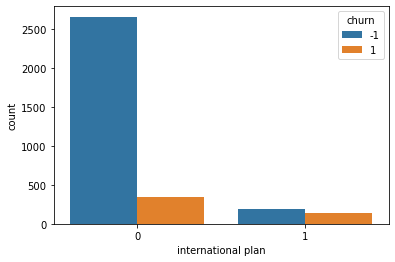

In [255]:
sb.countplot(x="international plan", hue="churn", data=da)

Let's Look separately on those who is using international plan and not using it

<AxesSubplot:xlabel='customer service calls', ylabel='count'>

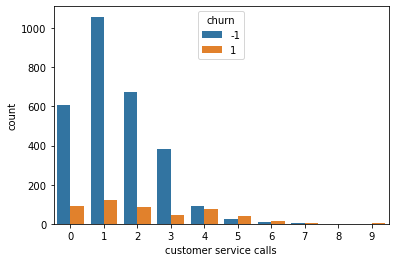

In [256]:
sb.countplot(x="customer service calls", hue="churn", data=da)

Churn proportions change for thos who call Customer service (>=4 times)

In [257]:
pd.crosstab(da["voice mail plan"],da["churn"])

churn,-1,1
voice mail plan,,
0,2008,403
1,842,80


users of voice mail are ~2 times more loyal

Now let's see it separrately:

In [258]:

df=da[da["international plan"]==1]
df.shape

(323, 21)

<AxesSubplot:xlabel='customer service calls', ylabel='count'>

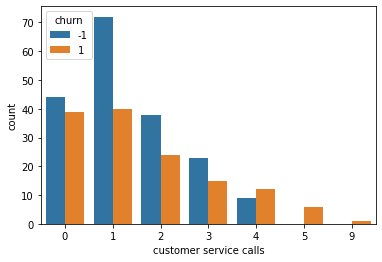

In [259]:
sb.countplot(x="customer service calls", hue="churn", data=df)

Picture changes significantly, as churn numbers almost do nott depend of the Customerr Service calls

<AxesSubplot:xlabel='voice mail plan', ylabel='count'>

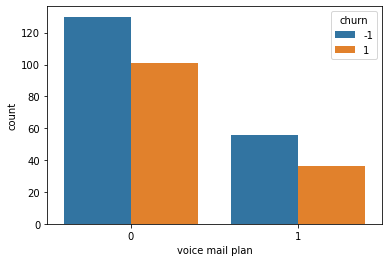

In [260]:
sb.countplot(x="voice mail plan", hue="churn", data=df)

The same is with the loyalty of the voice mail users

It means we need to search for dependencies for international and local callers separately. Let's see internationals first

In [261]:
pd.crosstab(df["total intl calls"],df["churn"])

churn,-1,1
total intl calls,,
1,0,13
2,0,47
3,51,22
4,47,13
5,25,8
6,22,12
7,16,8
8,8,2
9,8,6


Looks like some of the people are churning right after 1-2 international calls and it might be just tourists. Let's cut them and look on the rest:

<ipython-input-262-fe5ad393316e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nomads["prediction"] = 1


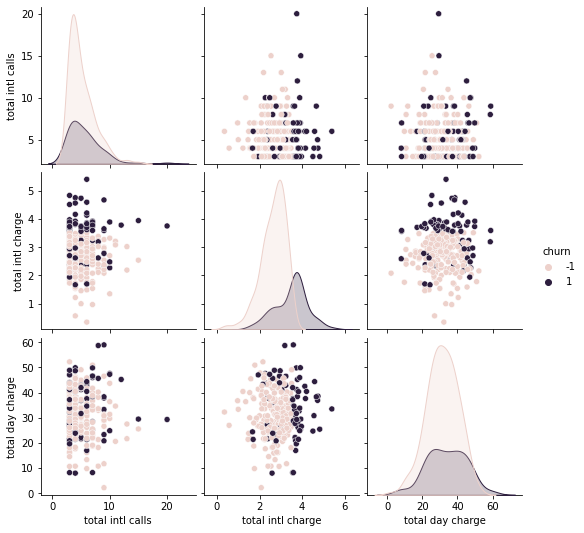

In [262]:
nomads = df[df["total intl calls"]<=2]
nomads["prediction"] = 1

intl_regular_callers = df[df["total intl calls"]>2]
cols = ["total intl calls","total intl charge"]

sb.pairplot(intl_regular_callers.loc[:,cols+["total day charge","churn"]],hue="churn")

Seems like that the main reason is the high charges (probably competitors provide lower rates for large volumes of international and day minutes:) Even though the 100% linear separation is impossible let's use it by intel charge and day charge values.

26  total in test, errors: 7.69%


<ipython-input-263-4ac1dec6f53a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intl_regular_callers["prediction"]=intl_regular_ppn.predict(intl_regular_callers.loc[:,cols])


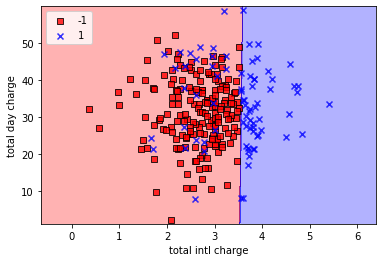

In [263]:
cols = ["total intl charge","total day charge"]
intl_regular_ppn = divide_frame(intl_regular_callers, cols,random_state_sample = 25,random_state_ppn = 1,iter = 500, eta = 0.1, fraction = 0.9)
intl_regular_callers["prediction"]=intl_regular_ppn.predict(intl_regular_callers.loc[:,cols])

plot_decision_regions(intl_regular_callers.loc[:,cols].values,intl_regular_callers["churn"].values,classifier = intl_regular_ppn)
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.legend(loc='upper left')


We have successfully divided it. 
Now let's see what is with local callers. We have found that voice mailers are loyal and those who call customer service often churn in the end:

In [264]:
df=da[da["international plan"]==0]

active = df[df['customer service calls']>=4] 
passive_callers = df[(df['customer service calls']<4) & (df['number vmail messages']==0)] 
passive_mailers = df[(df['customer service calls']<4) & (df['number vmail messages']>0)] 

Let's look on the passive mailers first:

In [265]:
passive_mailers[passive_mailers["churn"]==1]["churn"].count()/passive_mailers["churn"].count()

0.026041666666666668

only 2% of them churn, let's assume the do not churn at all for our model:

In [ ]:
passive_mailers["prediction"] = -1 # -1 is non-churn

Now let's see what happens with those who does not use voice mail at all and just calling:

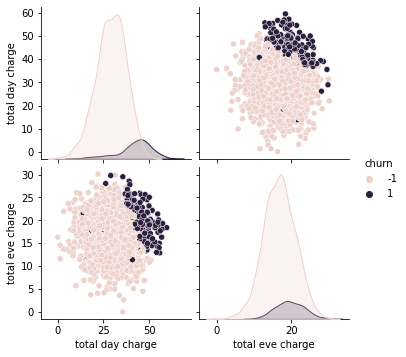

In [267]:
cols = ["total day charge","total eve charge"]
sb.pairplot(passive_callers.loc[:,cols + ["churn"]],hue="churn")

The same - charges matter, let's find right split by using the same linear division:

601  total in test, errors: 5.49%


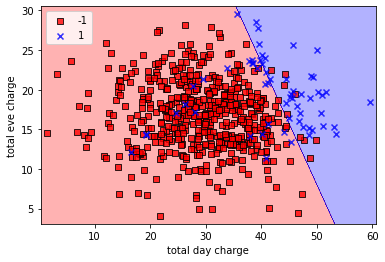

In [268]:
pnp_passive_callers = divide_frame(passive_callers,cols,random_state_sample = 1,random_state_ppn = 1,iter = 300, eta = 0.1, fraction = 0.7,plot = True)


In [ ]:
passive_callers["prediction"]=pnp_passive_callers.predict(passive_callers.loc[:,cols])

Finally let's see on those who calls Customer Service very often:

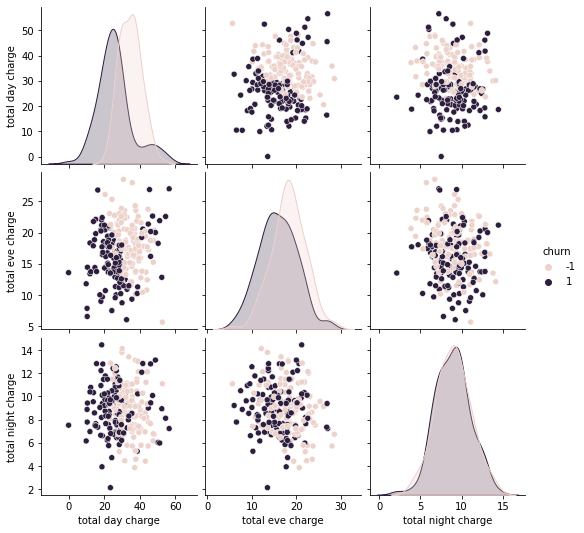

In [270]:
cols = ["total day charge","total eve charge","total night charge"]
sb.pairplot(active.loc[:,cols +["churn"]],hue = "churn")

As we can see there are 2 sets of (Total eve charge , Total day charge) values: those who rarely calls and hencce have low charges or those who have very high charges, but they are more rare. Let's extrtact the moddle part - those who call normal charges - by double separation

In [ ]:
cols = ["total day charge","total eve charge"]
active_A = active
percent = 100
for i in range(5):
    active_ppn1 = divide_frame(active_A,cols,random_state_sample = 1+i,random_state_ppn = 2+i,fraction = 0.7,eta = 0.1, iter = 4000)
    active_rest = active[active_ppn1.predict(active.loc[:,cols])==-1]
    active_ppn2 = divide_frame(active_rest,cols,random_state_sample = 4+i,random_state_ppn = 1+i,fraction = 0.7,eta = 0.1, iter = 4000)
    active_A = active[active_ppn2.predict(active.loc[:,cols])==-1]
    
    A = np.array(active_ppn1.predict(active.loc[:,cols])==-1)
    B = np.array(active_ppn2.predict(active.loc[:,cols])==-1)
    
    active["prediction"] = ~ (A & B)
    
    active["prediction"] = np.where(active["prediction"],1,-1)
    errors = abs(active["prediction"]-active["churn"])/2

    
    if percent >  100*errors.sum()/errors.count():
        percent = 100*errors.sum()/errors.count()
        appn1 = active_ppn1
        appn2 = active_ppn2
    #print(errors.count(),f" total, Round errors: {percent:.2f}%")

A = np.array(appn1.predict(active.loc[:,cols])==-1)
B = np.array(appn2.predict(active.loc[:,cols])==-1)
    
active["prediction"] = ~ (A & B)
active["prediction"] = np.where(active["prediction"],1,-1)

Let's visualize the splits:

239  total, active errors: 14.64%


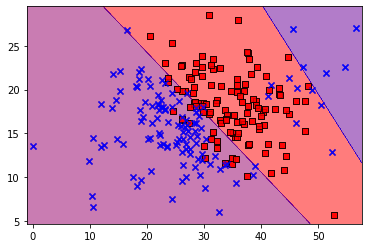

In [272]:
#check
plot_decision_regions(active.loc[:,["total day charge","total eve charge"]].values,active["churn"].values,classifier = appn1)
plot_decision_regions(active.loc[:,["total day charge","total eve charge"]].values,active["churn"].values,classifier = appn2)

errors = abs(active["prediction"]-active["churn"])/2
percent = 100*errors.sum()/errors.count()
print(errors.count(), f" total, active errors: {percent:.2f}%")


In [273]:
active.shape

(239, 22)

Of course we can add night charges and increase the the precision a bit, but since less than 10% users call often Customer service, then let's keep it with this precision.

Let's calculate the final result:

In [274]:
df = nomads.append(intl_regular_callers).append(active).append(passive_callers).append(passive_mailers)

In [283]:
df["prediction"] = np.where(df["prediction"] == 1, True, False)
df["churn"] = np.where(df["churn"] == 1, True, False)

sample = df.sample(random_state = 13, frac = 0.3)

errors = sample["prediction"] ^ sample["churn"]
precision = 100*(errors.count()-errors.sum())/errors.count()
print(errors.count(),f"records, total model precision: {precision:.2f}%")


1000 records, total model precision: 95.10%


Just to summarize the model I organized it into functions:

In [276]:
#dataset should contain "churn" column
def model_init(dataset):
    
    df = dataset[dataset["international plan"]==1]
    intl_regular_callers = df[df["total intl calls"]>2]
    
    df = dataset[dataset["international plan"]==0]
    active = df[df['customer service calls']>=4]
    passive_callers = df[(df['customer service calls']<4) & (df['number vmail messages']==0)]

    #international regular callers
    print("Creation of Perceptron for International regular callers")
    cols = ["total intl charge","total day charge"]
    intl_regular_ppn = divide_frame(intl_regular_callers, cols,random_state_sample = 2,random_state_ppn = 1,iter = 300, eta = 0.1, fraction = 0.7)

    print("Creation of Perceptron for regular local callers")
    #passive callers
    cols = ["total day charge","total eve charge","total night charge"]
    pnp_passive_callers = divide_frame(passive_callers,cols,random_state_sample = 4,random_state_ppn = 1,iter = 300, eta = 0.1, fraction = 0.7)

    #active
    print("Creation of Perceptron for Cusomer Service obsessed callers")
    cols = ["total day charge","total eve charge"]
    active_A = active
    percent = 100
    for i in range(5):
        active_ppn1 = divide_frame(active_A,cols,random_state_sample = 1+i,random_state_ppn = 2+i,fraction = 0.7,eta = 0.1, iter = 4000)
        active_rest = active[active_ppn1.predict(active.loc[:,cols])==-1]
        active_ppn2 = divide_frame(active_rest,cols,random_state_sample = 4+i,random_state_ppn = 1+i,fraction = 0.7,eta = 0.1, iter = 4000)
        active_A = active[active_ppn2.predict(active.loc[:,cols])==-1]
    
        A = np.array(active_ppn1.predict(active.loc[:,cols])==-1)
        B = np.array(active_ppn2.predict(active.loc[:,cols])==-1)
    
        active["prediction"] = ~ (A & B)
    
        active["prediction"] = np.where(active["prediction"],1,-1)
        errors = abs(active["prediction"]-active["churn"])/2

        if percent >  100*errors.sum()/errors.count():
            percent = 100*errors.sum()/errors.count()
            appn1 = active_ppn1
            appn2 = active_ppn2
        print(errors.count(), f", total errors: {percent:.2f}%")

#returns dataset with "prediction" column
def model_predict(dataset):
    
    df = dataset[dataset["international plan"]==1]
    #internatinal nomads
    df[df["total intl calls"]<=2]["prediction"]=True #100% churn
    #international regular callers
    cols = ["total intl charge","total day charge"]
    df[df["total intl calls"]>2]["prediction"]=intl_regular_ppn.predict(df[df["total intl calls"]>2].loc[:,cols])
    dataset[dataset["international plan"]==1]["prediction"] = (df["prediction"] == 1)

    df = dataset[dataset["international plan"]==0]
    
    active = df[df['customer service calls']>=4]
    passive_callers = df[(df['customer service calls']<4) & (df['number vmail messages']==0)]     
    passive_mailers = df[(df['customer service calls']<4) & (df['number vmail messages']>0)] 
    
    #only 2% of passive mailers churn
    passive_mailers["prediction"]=False 
    
    #passive callers are mainly churn because of the charges
    cols = ["total day charge","total eve charge","total night charge"]
    passive_callers["prediction"]=pnp_passive_callers.predict(passive_callers.loc[:,cols])
    np.where(passive_callers["prediction"] == 1,True,False)

    #while active customer serrviec callers also churn because of technical problems and churn with even small charges
    A = np.array(appn1.predict(active.loc[:,cols])==-1)
    B = np.array(appn2.predict(active.loc[:,cols])==-1)
    
    active["prediction"] = ~ (A & B)

    glue = active.append(passive_callers).append(passive_mailers)
    dataset[dataset["international plan"]==0]["prerdiction"] = glue["prediction"]

    return dataset

#dataset should contain "churn" column
def model_evaluate(dataset,fraction = 0.7, random = 1):
    
    sample = dataset.sample(random_state = random, frac = fraction)

    erorrs = sample["prediction"] ^ sample["churn"]
    percent = 100*errors.sum()/errors.count()
    print(f"Model evaluation with fraction {fraction}, random = {random}\n sample of {errors.count()} items\n, errors: {percent:.2f}%")